### Saving and loading models

This will be incredibly useful because you'll want to load previously trained models to use in making predictions or

In [3]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
# define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and load training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

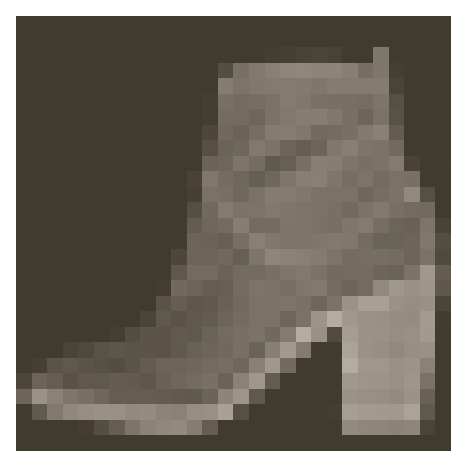

In [5]:
# sample image
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

### Train a network

In [7]:
# create network, define criterion and optimizer
# will use a new format of making a file called fc_model with our model architecture
import fc_model

model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.721..  Test Loss: 0.949..  Test Accuracy: 0.638
Epoch: 1/2..  Training Loss: 1.019..  Test Loss: 0.751..  Test Accuracy: 0.729
Epoch: 1/2..  Training Loss: 0.870..  Test Loss: 0.733..  Test Accuracy: 0.710
Epoch: 1/2..  Training Loss: 0.787..  Test Loss: 0.636..  Test Accuracy: 0.750
Epoch: 1/2..  Training Loss: 0.748..  Test Loss: 0.595..  Test Accuracy: 0.772
Epoch: 1/2..  Training Loss: 0.689..  Test Loss: 0.612..  Test Accuracy: 0.769
Epoch: 1/2..  Training Loss: 0.703..  Test Loss: 0.572..  Test Accuracy: 0.787
Epoch: 1/2..  Training Loss: 0.682..  Test Loss: 0.572..  Test Accuracy: 0.789
Epoch: 1/2..  Training Loss: 0.663..  Test Loss: 0.573..  Test Accuracy: 0.793
Epoch: 1/2..  Training Loss: 0.666..  Test Loss: 0.549..  Test Accuracy: 0.802
Epoch: 1/2..  Training Loss: 0.632..  Test Loss: 0.534..  Test Accuracy: 0.809
Epoch: 1/2..  Training Loss: 0.617..  Test Loss: 0.515..  Test Accuracy: 0.814
Epoch: 1/2..  Training Loss: 0.575..  Test Loss: 0.5

KeyboardInterrupt: 

Now that we don't want to train the model every time we need to use it, we can save the trained network for later loading.